This notebook demonstrates the key component of the Music Transformer paper on relative position embedding.

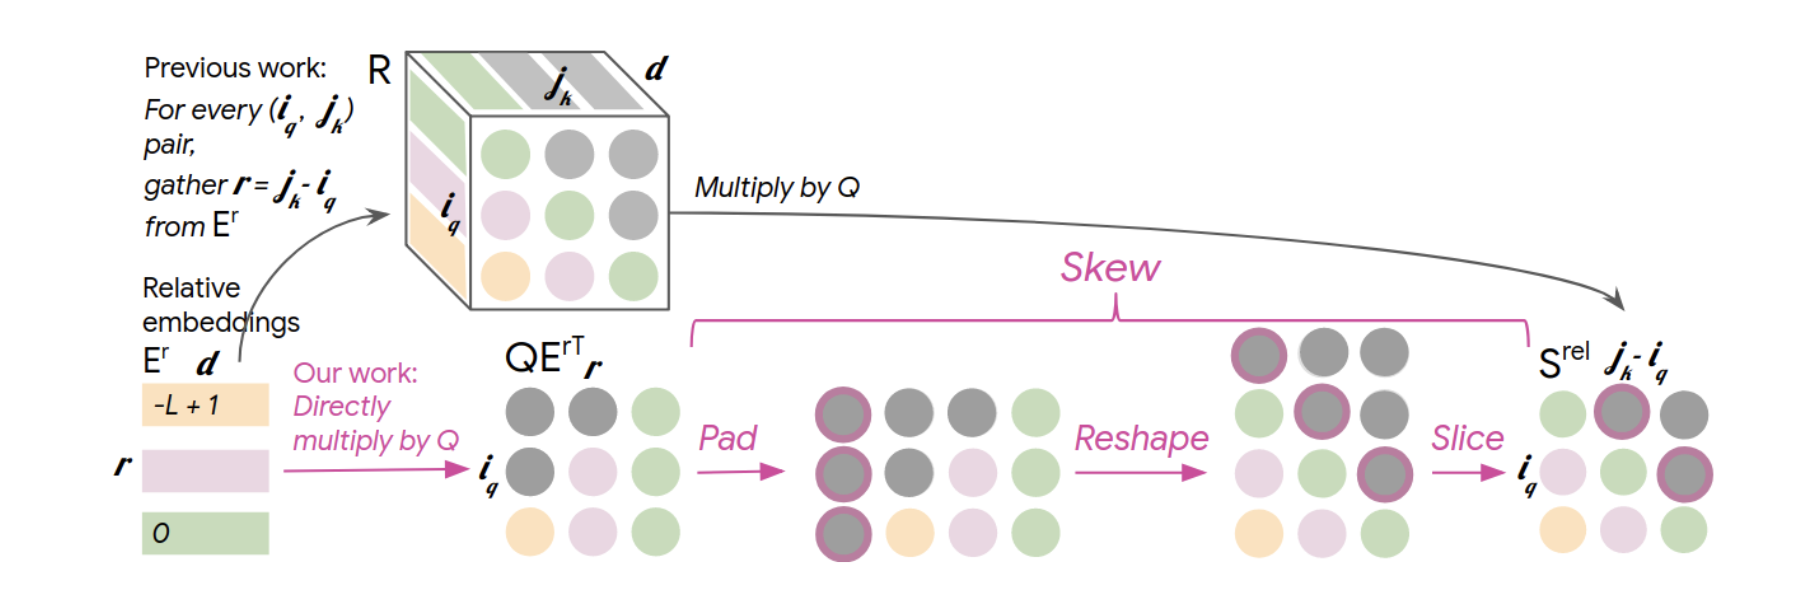

First, let's assume a model dimension of \(D=1\) and a sequence length of \(L=5\), and remove the dimensions of batches and heads.

Therefore, we will have:

- **Query dimension**: $R^Q = (L, D) = (5, 1)$
- **Embedding dimension**: $R^E = (L, D) = (5, 1)$

According to the paper, the relative position embedding has an embedding for each possible pairwise distance $r = j_k - i_q$ between a query and key at positions $i_q$ and $j_k$, respectively. The embeddings are ordered from distance $-L + 1$ to 0.

To better understand the relative position embeddings, let's initialize the Q and E as follows:


In [1]:
import torch
L, D = 5, 1
Q = torch.ones(L, D)
E = torch.arange(-L + 1, 1, dtype=Q.dtype).unsqueeze(1)
QEt = torch.matmul(Q, E.T)
print(E) 

tensor([[-4.],
        [-3.],
        [-2.],
        [-1.],
        [ 0.]])


In this example, we assign identical queries to each position and set the relative position $r = j_k - i_q$ as the embedding value. Note that the paper considers only causal attention, so there are no future relative positions. 

According to the illustration in the paper, we need to mask the left top blocks.


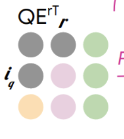

The QEt matrix looks like this

In [2]:
def mask_qe(QE):
    mask = torch.ones_like(QE)
    mask = mask.triu(diagonal=0).flip(0)
    return QE * mask

masked_QEt = mask_qe(QEt)

print(masked_QEt)

tensor([[-0., -0., -0., -0.,  0.],
        [-0., -0., -0., -1.,  0.],
        [-0., -0., -2., -1.,  0.],
        [-0., -3., -2., -1.,  0.],
        [-4., -3., -2., -1.,  0.]])


The last column corresponds to the green cells, the second column with a relative embedding of −1 corresponds to the pink cells, and so on.

Next, we need to create the Skew process. This ensures that when we add $QEt$ to $QK$, the relative position aligns with $i_k$ and $j_q$.

In [3]:
from torch.nn import functional as F
def skew(qe):
    rel_dist = qe.size(0) # get L 
    padded = F.pad(qe, (1, 0), "constant", -0.0) # 1. Pad a dummy column vector of length L before the leftmost column.
    srel = padded.reshape(rel_dist+1, rel_dist) # 2. Reshape the matrix to have shape (L +1,L)
    srel = srel[1:] # 3. slice the matrix to remove the first row
    return srel

The final matrix $S_{rel}$ is: 

In [4]:
srel = skew(masked_QEt)
print(srel)

tensor([[ 0., -0., -0., -0., -0.],
        [-1.,  0., -0., -0., -0.],
        [-2., -1.,  0., -0., -0.],
        [-3., -2., -1.,  0., -0.],
        [-4., -3., -2., -1.,  0.]])


## Local relative attention

Now, let's see how we could implement local relative attention. The differences between global attention and local attention are:

- **QEt Masking**
- **Padding**


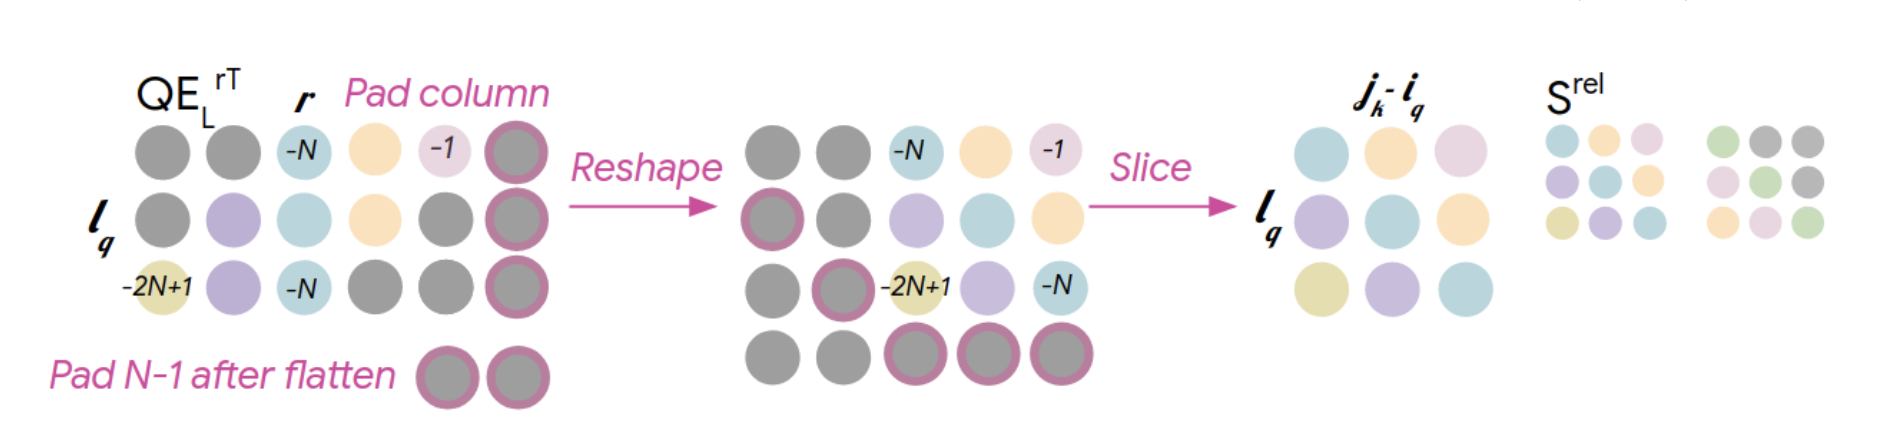

In [5]:
# local attention is used by chunking the input sequence into non-overlapping blocks with a fixed size N = (L/M)
N = 5
Q = torch.ones(N, D) 
E = torch.arange(- 2 * N + 1, 0, dtype=Q.dtype).unsqueeze(1)
print(E)

tensor([[-9.],
        [-8.],
        [-7.],
        [-6.],
        [-5.],
        [-4.],
        [-3.],
        [-2.],
        [-1.]])


In [6]:
QEt = torch.matmul(Q, E.T)
print(QEt)

tensor([[-9., -8., -7., -6., -5., -4., -3., -2., -1.],
        [-9., -8., -7., -6., -5., -4., -3., -2., -1.],
        [-9., -8., -7., -6., -5., -4., -3., -2., -1.],
        [-9., -8., -7., -6., -5., -4., -3., -2., -1.],
        [-9., -8., -7., -6., -5., -4., -3., -2., -1.]])


In [7]:
def mask_qe(QEt):
    mask = torch.ones_like(QEt)
    # we need to mask the upper left and lower right triangle based on the block size N
    mask = mask.triu(diagonal=0).flip(0) * mask.triu(diagonal=0).flip(1) 
    return QEt * mask

In [8]:
masked_qet = mask_qe(QEt)
print(masked_qet)

tensor([[-0., -0., -0., -0., -5., -4., -3., -2., -1.],
        [-0., -0., -0., -6., -5., -4., -3., -2., -0.],
        [-0., -0., -7., -6., -5., -4., -3., -0., -0.],
        [-0., -8., -7., -6., -5., -4., -0., -0., -0.],
        [-9., -8., -7., -6., -5., -0., -0., -0., -0.]])


In [9]:
def skew(qe):
    padded = F.pad(qe, (0, 1), "constant", -0.0) # 1. Pad a dummy column vector of length N after the rightmost column.
    flatten = padded.flatten() # 2. Flatten the matrix and then pad with a dummy row of length N − 1.
    padded2 = F.pad(flatten, (0, N-1), "constant", -0.0) 
    reshaped = padded2.reshape(N+1, 2*N - 1) # 3. Reshape the matrix to have shape (N + 1, 2N − 1).
    srel = reshaped[:N, -N:] # 4. Slice that matrix to retain only the first N rows and last N columns, resulting in a (N,N) matrix.
    return srel

In [10]:
srel = skew(masked_qet)
print(srel)

tensor([[-5., -4., -3., -2., -1.],
        [-6., -5., -4., -3., -2.],
        [-7., -6., -5., -4., -3.],
        [-8., -7., -6., -5., -4.],
        [-9., -8., -7., -6., -5.]])
